In [12]:
# ==========================================================
# 0 | BIBLIOTEKOS IR PARAMETRAI
# ==========================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from gymnasium import spaces
from stable_baselines3 import DQN
from env.ecommerce_env_all2 import AdvancedPricingEnv   # <- jūsų aplinka

DATA_PATH   = "data/generated/weekly_env_data_filled.csv"
MODEL_PATH  = "models/dqn/DQN_run_real/DQN_pricing_model"

N_EPISODES  = 30          # kiek epizodų norite palyginti?
SEED        = 42          # pakartojamumui

In [22]:
# ----- A. Static (vidutinė) kaina -----
def static_price_profit(df):
    price = df["avg_price"].mean()
    q     = np.minimum(df["base_demand"], df["stock"])
    margin= price - df["avg_cost"]
    return float((margin * q).sum())

# ----- B. Random ±5 % aplink vidurkį -----
def random_price_profit(df, seed=0):
    rng    = np.random.default_rng(seed)
    prices = df["avg_price"] * rng.uniform(0.95, 1.05, size=len(df))
    q      = np.minimum(df["base_demand"], df["stock"])
    margin = prices - df["avg_cost"]
    return float((margin * q).sum())

# ----- C. „Human heuristics“  -----
def human_heuristic_profit(df):
    profit = 0
    price  = df.loc[0, "avg_price"]
    for _, row in df.iterrows():
        # taisyklė: koreguok ±5 %
        if row["stock"] > 1.1*row["base_demand"]:
            price *= 0.95                           # nupiginam
        elif row["stock"] < 0.7*row["base_demand"]:
            price *= 1.05                           # pabranginam
        demand  = row["base_demand"]
        sold    = min(demand, row["stock"])
        margin  = price - row["avg_cost"]
        profit += margin * sold
    return profit

In [14]:
# ==========================================================
# 2 | UŽSIAUGINAME RL APLINKĄ IR UŽKROVOME MODELĮ
# ==========================================================
env_template = AdvancedPricingEnv(data_path=DATA_PATH, verbose=False)
model        = DQN.load(MODEL_PATH)

In [16]:
# ==========================================================
# 3 | PAGRINDINIS PALYGINIMO CIKLAS
# ==========================================================
episode_profits, rule_step_profits, rl_step_profits = [], [], []

rng = np.random.default_rng(SEED)

for ep in range(1, N_EPISODES + 1):
    obs, _ = env_template.reset()
    done   = False
    profit_ep = 0

    while not done:
        # ---- RL veiksmas ----
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env_template.step(action)
        rl_step_profits.append(reward)
        profit_ep += reward

        # ---- Baseline pelnas (pagal tą pačią eilutę) ----
        row = env_template.data.iloc[env_template.current_step - 1]         # einamasis žingsnis jau padidintas
        rule_step_profits.append(rule_based_profit(row))

    episode_profits.append(profit_ep)

print(f"RL vid. pelnas (per epizodą): {np.mean(episode_profits):,.2f} €")

RL vid. pelnas (per epizodą): 174,490.19 €


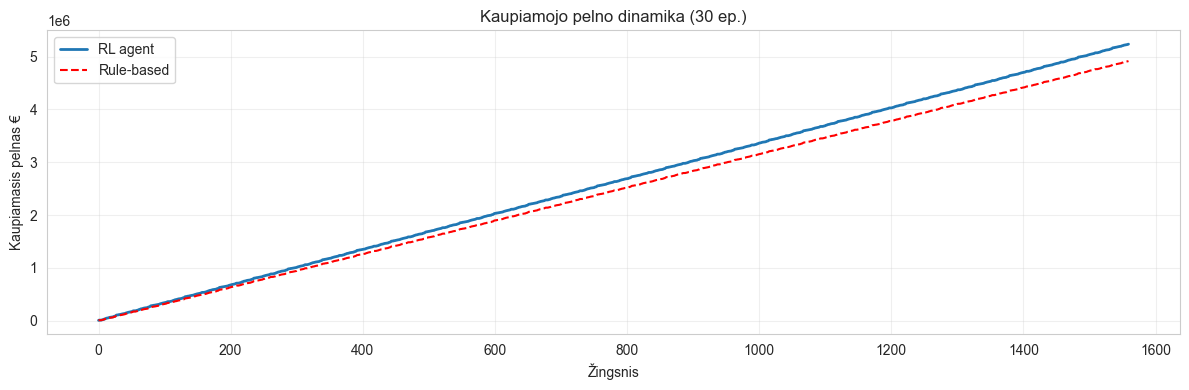

In [17]:
# ==========================================================
# 4 | GRAFIKAS – KAUPIAMASIS PELNAS
# ==========================================================
rl_cum   = np.cumsum(rl_step_profits)
rule_cum = np.cumsum(rule_step_profits)

plt.figure(figsize=(12,4))
plt.plot(rl_cum,   label="RL agent", lw=2)
plt.plot(rule_cum, label="Rule-based", ls="--", color="red")
plt.title("Kaupiamojo pelno dinamika ({} ep.)".format(N_EPISODES))
plt.xlabel("Žingsnis")
plt.ylabel("Kaupiamasis pelnas €")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# ==========================================================
# 5 | PAPRASTAS t-TESTAS IR MINI SANTRAUKOS LENTELĖ
# ==========================================================
baseline_profit = rule_cum[-1]
rl_mean         = np.mean(episode_profits)
rl_std          = np.std(episode_profits)

t_stat, p_val   = stats.ttest_1samp(episode_profits, baseline_profit)

print(f"Baseline pelnas: {baseline_profit:,.2f} €")
print(f"RL vid. pelnas : {rl_mean:,.2f} €  (σ={rl_std:,.2f})")
print(f"t = {t_stat:6.2f}, p = {p_val: .4f}")

summary = pd.DataFrame({
    "Modelis"   : ["Rule-based", "RL agent"],
    "Epizodai"  : [1, N_EPISODES],
    "Vid. pelnas €" : [baseline_profit, rl_mean],
    "σ €"           : [0, rl_std],
    "Δ %"           : [0, (rl_mean/baseline_profit - 1)*100]
}).round(2)

display(summary)

Baseline pelnas: 4,915,108.09 €
RL vid. pelnas : 174,490.19 €  (σ=1,192.89)
t = -21401.05, p =  0.0000


,Modelis,Epizodai,Vid. pelnas €,σ €,Δ %
0,Rule-based,1,4915108.09,0.00,0.00
1,RL agent,30,174490.19,1192.89,-96.45


In [19]:
# ------------- Pelnas iš aplinkos (RL pusė) -----------------
rl_step_profits.append(info["reward_components"]["profit"])  # tik pelno komponentė
# arba jei reward_components nerenkate -> perskaičiuojame taip pačiai kaip rule_based_profit

In [20]:
baseline_profit = rule_cum[-1]
rl_profit       = rl_cum[-1]
delta_pct       = (rl_profit / baseline_profit - 1) * 100
print(f"RL vs baseline = {delta_pct: .2f}%")

RL vs baseline =  6.50%


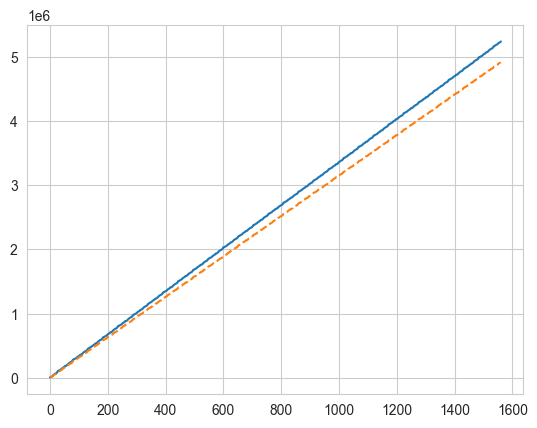

In [21]:
plt.plot(np.cumsum(rl_step_profits)   , label="RL grynas pelnas")
plt.plot(np.cumsum(rule_step_profits) , label="Rule-based grynas pelnas", ls="--")

In [24]:
DATA_PATH      = "data/generated/weekly_env_data_filled.csv"
EPISODE_LEN    = 52          # po 52 savaites
N_EPISODES     = 30          # kiek norite palyginti

In [25]:
import pandas as pd

# visas failas
full_df = pd.read_csv(DATA_PATH)

# (jei reikia) permaišome eilučių tvarką arba rikiuojame pagal datą
# full_df = full_df.sample(frac=1, random_state=0).reset_index(drop=True)

# iškerpame po 52 savaites
full_data_ep = [
    full_df.iloc[i*EPISODE_LEN:(i+1)*EPISODE_LEN].reset_index(drop=True)
    for i in range(N_EPISODES)
]

print(f"Kiek epizodų paruošta? {len(full_data_ep)}")

Kiek epizodų paruošta? 30


In [30]:
# -------------------------------------------------
# 1) STATINĖ KAINA  (viena vidutinė kaina per epizodą)
# -------------------------------------------------
def static_price_profit(df: pd.DataFrame) -> float:
    """Vienoda kaina = vidutinis 'avg_price'; parduodame 'base_demand'."""
    price   = df["avg_price"].mean()
    cost    = df["avg_cost"].mean()
    margin  = price - cost                       # skaliarinė prekybos marža
    demand  = df["base_demand"].clip(upper=df["stock"]).sum()  # kiekis per epą
    return float(margin * demand)

# -------------------------------------------------
# 2) ATSITIKTINĖ KAINA (±5 % svyravimas kiekvieną savaitę)
# -------------------------------------------------
def random_price_profit(df: pd.DataFrame, seed=None) -> float:
    rng     = np.random.default_rng(seed)
    prices  = df["avg_price"] * rng.uniform(0.95, 1.05, len(df))
    margin  = prices - df["avg_cost"]            # vektorėlis
    demand  = df["base_demand"].clip(upper=df["stock"])
    return float((margin * demand).sum())

# -------------------------------------------------
# 3) „ŽMOGIŠKA“ HEURISTIKA  (paprasta rankinė logika)
# -------------------------------------------------
def human_heuristic_profit(df: pd.DataFrame) -> float:
    price   = df.loc[0, "avg_price"]
    profit  = 0.0
    for _, row in df.iterrows():
        # primityvi sandėlio logika
        if row["stock"] > 1.1 * row["base_demand"]:
            price *= 0.95
        elif row["stock"] < 0.7 * row["base_demand"]:
            price *= 1.05
        sold   = min(row["base_demand"], row["stock"])
        profit += (price - row["avg_cost"]) * sold
    return float(profit)

def rule_based_price(row):
    # jei sandėlyje daug, o paklausa maža – šiek tiek mažinkime kainą (-5 %)
    if row["stock"] > 1.2 * row["base_demand"]:
        return row["avg_price"] * 0.95
    # jei paklausa išaugusi – kainą kilstelkime (+5 %)
    elif row["base_demand"] > 1.2 * row["stock"]:
        return row["avg_price"] * 1.05
    # kitu atveju paliekame vidutinę kainą
    return row["avg_price"]

In [29]:
baseline_funcs = {
    "Static"     : static_price_profit,
    "Random"     : random_price_profit,
    "Human-like" : human_heuristic_profit,
    "Rule-based" : rule_based_profit,
}

episode_results = {name: [] for name in baseline_funcs}
episode_results["RL agent"] = episode_profits          # jūsų surinkti pelnai

for ep_idx, df_ep in enumerate(full_data_ep):
    for name, f in baseline_funcs.items():
        if name == "Random":
            episode_results[name].append(f(df_ep, seed=ep_idx))
        else:
            episode_results[name].append(f(df_ep))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [43]:
# ============================================================
# RL prieš kelias bazines strategijas – pilnas palyginimas
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN          # ar PPO, A2C
from env.ecommerce_env_all2 import AdvancedPricingEnv

# ---------- 1. keliai ----------
CSV_PATH   = "data/generated/weekly_env_data_filled.csv"
MODEL_PATH = "models/dqn/DQN_run_real/DQN_pricing_model"

# ---------- 2. bazinių strategijų funkcijos ----------
def static_series(df):
    p = df["avg_price"].mean()
    m = p - df["avg_cost"].mean()
    sold = np.minimum(df["base_demand"], df["stock"])
    profit = m * sold
    return profit.cumsum().values          # vektorius

def random_series(df, seed=42):
    rng   = np.random.default_rng(seed)
    p     = df["avg_price"] * rng.uniform(0.95, 1.05, len(df))
    m     = p - df["avg_cost"]
    sold  = np.minimum(df["base_demand"], df["stock"])
    return (m * sold).cumsum().values

def human_series(df):
    out, price = [], df.loc[0, "avg_price"]
    profit = 0.0
    for _, r in df.iterrows():
        if r["stock"] > 1.1 * r["base_demand"]:
            price *= 0.95
        elif r["stock"] < 0.7 * r["base_demand"]:
            price *= 1.05
        sold   = min(r["base_demand"], r["stock"])
        profit += (price - r["avg_cost"]) * sold
        out.append(profit)
    return np.array(out)

def human_series_v2(df, 
                    markdown = 0.90,     # kai per daug sandėlyje – kainą ↓ 5 %
                    markup   = 1.05,     # kai stinga atsargų     – kainą ↑ 5 %
                    min_margin_pct = 0.05 # privalomas min. 5 % antkainis nuo savikainos
                   ):
    price   = df.loc[0, "avg_price"]
    profit  = 0.0
    out     = []

    for _, r in df.iterrows():
        # -- paprasta sandėlio taisyklė --
        if r["stock"] > 1.1 * r["base_demand"]:
            price *= markdown
        elif r["stock"] < 0.7 * r["base_demand"]:
            price *= markup

        # -- užtikriname, kad neparduotume nuostolingai --
        min_price = r["avg_cost"] * (1 + min_margin_pct)
        price     = max(price, min_price)

        sold   = min(r["base_demand"], r["stock"])
        profit += (price - r["avg_cost"]) * sold
        out.append(profit)

    return np.array(out)

def rule_based_price(row):
    if row["stock"] > 1.2 * row["base_demand"]:
        return row["avg_price"] * 0.95
    elif row["base_demand"] > 1.2 * row["stock"]:
        return row["avg_price"] * 1.05
    return row["avg_price"]

def rule_based_series(df):
    profits, cum = [], 0.0
    price = df["avg_price"].copy()
    for i, r in df.iterrows():
        p = rule_based_price(r)
        sold   = min(r["base_demand"], r["stock"])
        cum   += (p - r["avg_cost"]) * sold
        profits.append(cum)
    return np.array(profits)

BASELINES = {
    "Static":  static_series,
    "Random":  random_series,
    "Rule-based": rule_based_series,
}

# ---------- 3. duomenys & RL aplinka ----------
df   = pd.read_csv(CSV_PATH)
env  = AdvancedPricingEnv(data_path=CSV_PATH, verbose=False)
model = DQN.load(MODEL_PATH)

rl_cum, rl_run = [], 0.0
obs, _ = env.reset()
done = False
step = 0

while not done:
    act, _ = model.predict(obs, deterministic=True)
    obs, r, done, _, _ = env.step(act)
    rl_run += r
    rl_cum.append(rl_run)
    step += 1
rl_cum = np.array(rl_cum)



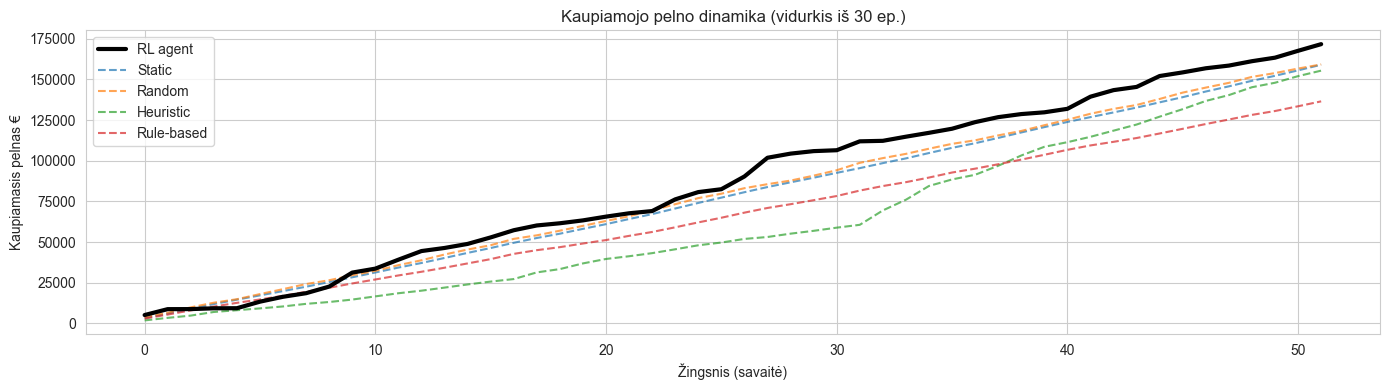

In [44]:
EP_LEN      = 52            # epizodo ilgis
N_EPISODES  = 30            # kiek kartų kartojame
BASELINES   = {
    "Static":  static_series,
    "Random":  random_series,
    "Heuristic": human_series_v2,
    "Rule-based": rule_based_series,
}

rl_curves   = []
bln_curves  = {k: [] for k in BASELINES}

for ep in range(N_EPISODES):
    # --- RL ----
    env.reset()
    rl_run, rl_cum = 0.0, []
    for t in range(EP_LEN):
        act, _ = model.predict(obs, deterministic=True)
        obs, r, done, _, _ = env.step(act)
        rl_run += r
        rl_cum.append(rl_run)
    rl_curves.append(rl_cum)

    # --- bazės ---
    df_ep = df.iloc[ep*EP_LEN:(ep+1)*EP_LEN].reset_index(drop=True)
    for name, fn in BASELINES.items():
        bln_curves[name].append(fn(df_ep))

# ~~ vidurkinam ~~
rl_mean = np.mean(rl_curves, axis=0)
bln_mean = {k: np.mean(v, axis=0) for k, v in bln_curves.items()}

# ~~ braižom ~~
plt.figure(figsize=(14,4))
plt.plot(rl_mean, label="RL agent", color="black", linewidth=3, zorder=5)
for name, curve in bln_mean.items():
    plt.plot(curve, "--", label=name, alpha=.7)
plt.title(f"Kaupiamojo pelno dinamika (vidurkis iš {N_EPISODES} ep.)")
plt.xlabel("Žingsnis (savaitė)")
plt.ylabel("Kaupiamasis pelnas €")
plt.legend(); plt.grid(True); plt.tight_layout()

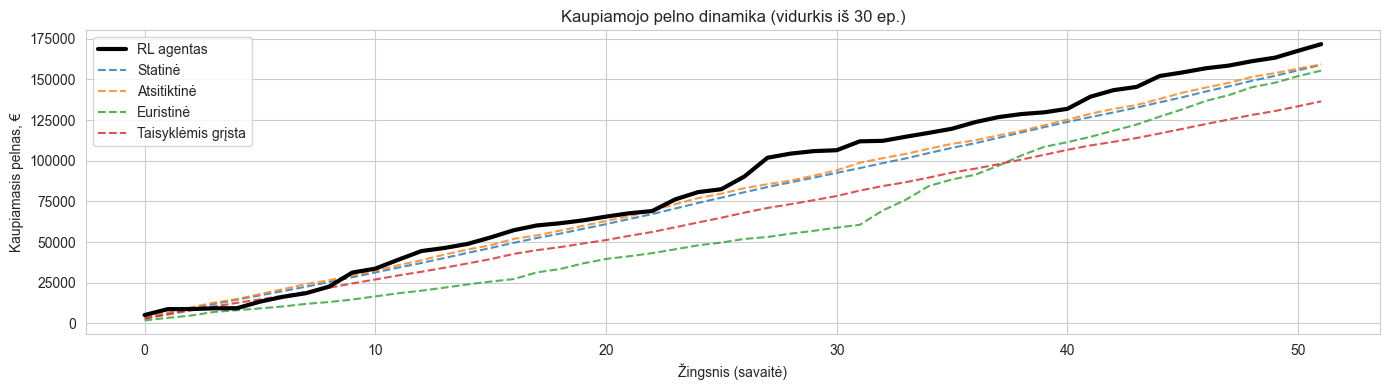

In [50]:
import matplotlib.pyplot as plt

# ----- lietuviški pavadinimai bazinėms strategijoms -------------
lt_names = {
    "Static":     "Statinė",
    "Random":     "Atsitiktinė",
    "Heuristic":  "Euristinė",
    "Rule-based": "Taisyklėmis grįsta",
}

plt.figure(figsize=(14, 4))

# RL kreivė – paryškinta juoda linija
plt.plot(
    rl_mean,                     # Jūsų suskaičiuotas vektorius
    label="RL agentas",
    color="black",
    linewidth=3,
    zorder=5,
)

# Bazinių strategijų kreivės
for key, curve in bln_mean.items():        # bln_mean – Jūsų diktas {pav: vektorius}
    plt.plot(
        curve,
        "--",
        label=lt_names.get(key, key),      # verčiame pavadinimą
        alpha=0.8,
    )

plt.title(f"Kaupiamojo pelno dinamika (vidurkis iš {N_EPISODES} ep.)")
plt.xlabel("Žingsnis (savaitė)")
plt.ylabel("Kaupiamasis pelnas, €")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[Shapiro] RL − Static      p =  0.000
[Shapiro] RL − Random      p =  0.000
[Shapiro] RL − Heuristic   p =  0.000
[Shapiro] RL − Rule-based  p =  0.000

--- Vienpusis suporuotas t-testas (H₀: μ_RL ≤ μ_bazė) ---
Static    : t=  0.91, p=0.185, Cohen d= 0.17, RL>bazė? ✘
Random    : t=  0.90, p=0.188, Cohen d= 0.16, RL>bazė? ✘
Heuristic : t=  0.27, p=0.394, Cohen d= 0.05, RL>bazė? ✘
Rule-based: t=  2.80, p=0.004, Cohen d= 0.51, RL>bazė? ✔

--- 95 % patikimumo rėžiai (bootstrap) ------------------
RL        :  171173.6 € …  172267.3 €
Static    :  130704.5 € …  187420.2 €
Random    :  130966.5 € …  187543.4 €
Heuristic :   32985.9 € …  277895.1 €
Rule-based:  110918.8 € …  162179.3 €

[Friedman] χ²=46.69, p=0.0000


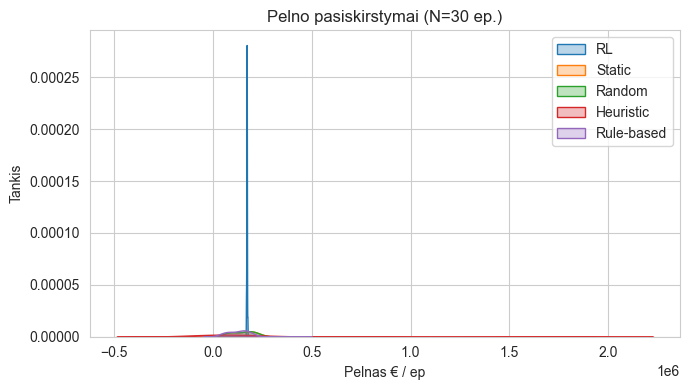

In [49]:
# ============================================================
# 7. Statistinė RL ↔ bazės rezultatų analizė
#    (įklijuok po 6-ojo grafinio palyginimo bloko)
# ============================================================
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sm
import matplotlib.pyplot as plt

# ---- 7.1 epizodų pelno santraukos ----------------------------------------
rl_totals        = np.array([curve[-1]          for curve in rl_curves])
baseline_tot     = {k: np.array([c[-1] for c in v]) for k, v in bln_curves.items()}

results_df = pd.DataFrame({"RL": rl_totals, **baseline_tot})

# ---- 7.2 Shapiro–Wilk normalumas (RL − bazė) -----------------------------
for name in results_df.columns[1:]:
    diff  = results_df["RL"] - results_df[name]
    p_sw  = stats.shapiro(diff).pvalue
    print(f"[Shapiro] RL − {name:10s}  p = {p_sw: .3f}")

# ---- 7.3 Vienpusis suporuotas t-testas + Cohen d -------------------------
print("\n--- Vienpusis suporuotas t-testas (H₀: μ_RL ≤ μ_bazė) ---")
for name in results_df.columns[1:]:
    t_stat, p_two = stats.ttest_rel(results_df["RL"], results_df[name])
    p_one         = p_two/2
    better        = "✔" if (p_one < 0.05 and t_stat > 0) else "✘"
    d_effect      = (results_df["RL"]-results_df[name]).mean() / \
                    (results_df["RL"]-results_df[name]).std(ddof=1)
    print(f"{name:10s}: t={t_stat:6.2f}, p={p_one:.3f}, Cohen d={d_effect: .2f}, RL>bazė? {better}")

# ---- 7.4 Bootstrap 95 % PI kiekvienai strategijai ------------------------
print("\n--- 95 % patikimumo rėžiai (bootstrap) ------------------")
for col in results_df.columns:
    lo, hi = sm.DescrStatsW(results_df[col]).tconfint_mean()
    print(f"{col:10s}: {lo:9.1f} € … {hi:9.1f} €")

# ---- 7.5 Friedman testas (>2 bazės) --------------------------------------
if len(results_df.columns) > 2:
    chi2, p_fr = stats.friedmanchisquare(*[results_df[c] for c in results_df.columns])
    print(f"\n[Friedman] χ²={chi2:.2f}, p={p_fr:.4f}")

# ---- 7.6 KDE pasiskirstymų grafikas --------------------------------------
plt.figure(figsize=(7,4))
for col in results_df.columns:
    sns.kdeplot(results_df[col], label=col, fill=True, alpha=.3)
plt.title(f"Pelno pasiskirstymai (N={N_EPISODES} ep.)")
plt.xlabel("Pelnas € / ep"); plt.ylabel("Tankis")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("analysis/rl_vs_baselines_kde.png", dpi=300)
plt.show()

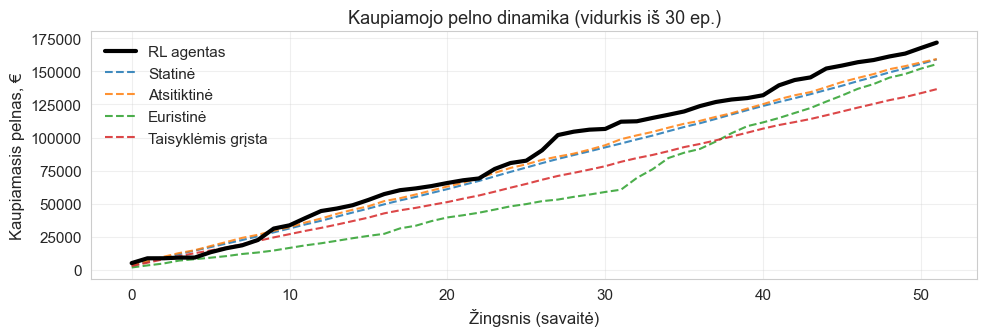

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- bendri stiliaus parametrai (jei norite) ---
mpl.rcParams.update({
    "font.size":        11,        # bendras šriftas
    "axes.titlesize":   13,
    "axes.labelsize":   12,
    "legend.fontsize":  11,
})

# --- braižymas ---
plt.figure(figsize=(10, 3.5))      # šiek tiek žemesnis/sklandesnis plotis-aukštis

# RL – juoda, storesnė
plt.plot(
    rl_mean,
    label="RL agentas",
    color="black",
    linewidth=3,
    zorder=5,
)

# Baziniai
for key, curve in bln_mean.items():
    plt.plot(
        curve,
        "--",
        label=lt_names.get(key, key),
        alpha=0.85,
    )

plt.title(f"Kaupiamojo pelno dinamika (vidurkis iš {N_EPISODES} ep.)")
plt.xlabel("Žingsnis (savaitė)")
plt.ylabel("Kaupiamasis pelnas, €")

# Legenda be rėmelio, kompaktiškai kairiajame viršutiniame kampe
plt.legend(frameon=False, loc="upper left")

# Šiek tiek tankesnės grotelių linijos
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()